LLano Estacado (White Deer) Wind Farm Data

In [1]:
# Use virtual environment "h2_ws" to run the program
# conda activate h2_ws

In [2]:
# Set up libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.dates as mdates
from pathlib import Path
import os
import numpy as np

# Check versions
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 2.2.3
NumPy version: 2.1.2


In [3]:
# Define the path to the input Excel file and the sheet name
file_path = Path(
    "historical_wdwf_data/input-file-EnergyDetails_2019-10-01_2020-09-30.xlsx"
)
sheet_name = "Data_Entity"

# Read the specified range from the Excel file
wind_data = pd.read_excel(
    file_path, sheet_name=sheet_name, usecols="A:V", skiprows=1, nrows=105409
)

In [4]:
# Ensure Date column is in datetime format (though it should already be)
wind_data.iloc[:, 1] = pd.to_datetime(wind_data.iloc[:, 1])

# Inspect and convert Time column to hh:mm:ss format if necessary
time_column = wind_data.iloc[:, 2]

# Replace '24:00' with '00:00' and add one day to the corresponding date
time_column = time_column.replace("24:00", "00:00")
wind_data.iloc[:, 1] = wind_data.iloc[:, 1] + pd.to_timedelta(
    (time_column == "00:00").astype(int), unit="D"
)

In [5]:
# Convert the time column to hh:mm:ss format if necessary
if not time_column.str.match(r"^\d{2}:\d{2}:\d{2}$").all():
    # Assuming the time column is in a different format, e.g., hh:mm or hh:mm:ss.sss
    # Clean and convert to hh:mm:ss format
    def clean_time_string(time_str):
        # Extract the time part using regex
        match = re.search(r"\d{2}:\d{2}(:\d{2})?", time_str)
        if match:
            return match.group(0)
        return "00:00:00"  # Default value if no match found

    wind_data.iloc[:, 2] = time_column.apply(
        lambda x: pd.to_datetime(clean_time_string(x)).strftime("%H:%M:%S")
    )

# Convert Time column to timedelta and add to Date to form a complete Datetime
wind_data["Datetime"] = wind_data.iloc[:, 1] + pd.to_timedelta(wind_data.iloc[:, 2])

# Set Datetime as the index of the DataFrame
wind_data.set_index("Datetime", inplace=True)

# Sort the DataFrame by the Datetime index
wind_data.sort_index(inplace=True)

# Convert generation data in column index 6 to the opposite of its existing value
wind_data.iloc[:, 6] = wind_data.iloc[:, 6] * -1

# Rename columns to lowercase and replace spaces with underscores
wind_data.columns = wind_data.columns.str.lower().str.replace(" ", "_")

In [6]:
# Filter data for the specified date range
start_date = "2019-10-01"
end_date = "2019-10-08"
filtered_wind_data = wind_data.loc[start_date:end_date]

# Extract the 'real-time lmp price' column
lmp_prices = filtered_wind_data["real-time_lmp_[$/mwh]"]

# Extract the real levelized cost of hydrogen with 45V PTC (LCOH) column
# lcoh_45v = filtered_wind_data['real_levelized_cost_45v_ptc_[$/kgh2]']
# LCOH is not correct, ignoring it for now

# Calculate the average
average_lmp_price = lmp_prices.mean()
max_lmp_price = lmp_prices.max()
min_lmp_price = lmp_prices.min()

# LCOH calculations are commented out as the column is not correct
# average_lcoh_45v = lcoh_45v.mean()
# max_lcoh_45v = lcoh_45v.max()
# min_lcoh_45v = lcoh_45v.min()

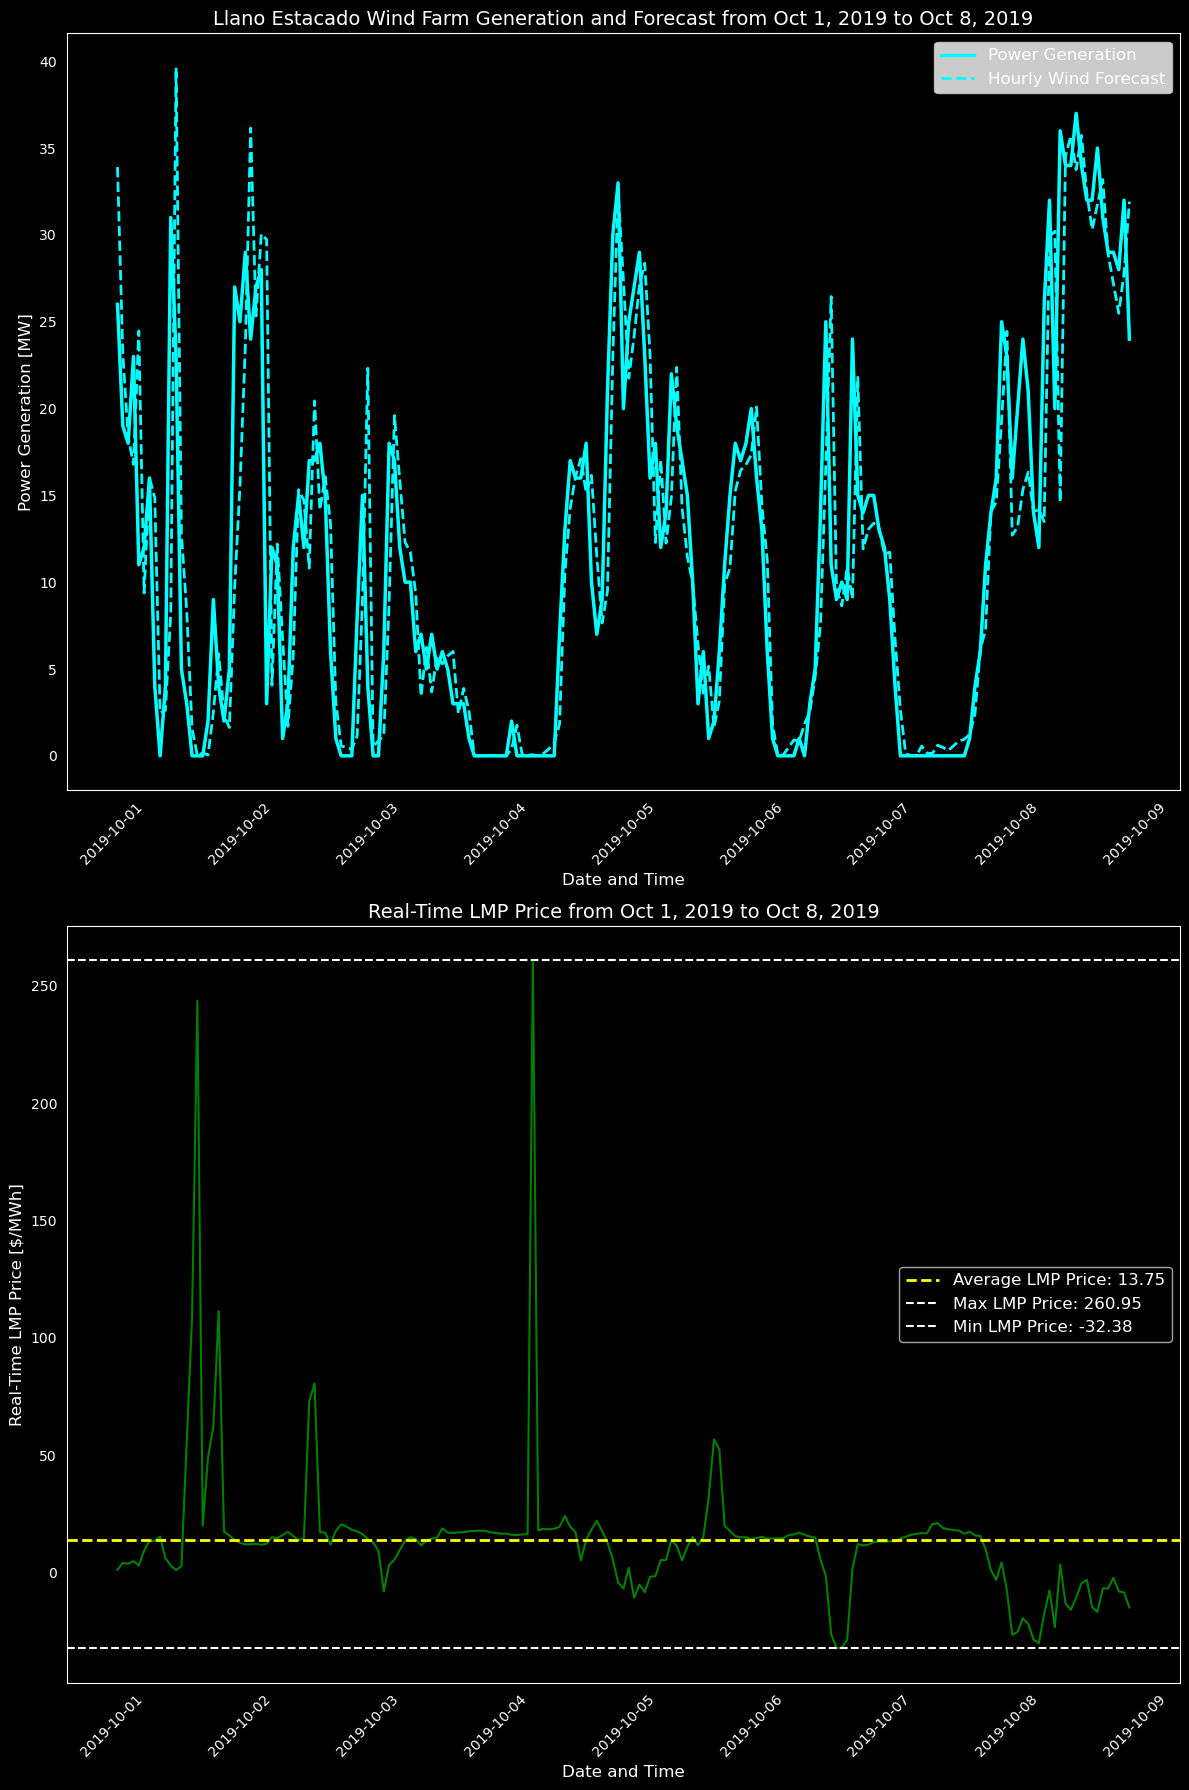

In [7]:
# Plot power generation and hourly wind forecast
plt.figure(figsize=(12, 18))  # Increase the height to accommodate all three plots

# Plot power generation (assuming it's in column index 6, which is the 7th column)
plt.subplot(2, 1, 1)
sns.lineplot(
    data=filtered_wind_data,
    x=filtered_wind_data.index,
    y=filtered_wind_data.iloc[:, 6],
    label="Power Generation",
    linestyle="-",
    color="cyan",
    linewidth=2.5,
)
sns.lineplot(
    data=filtered_wind_data,
    x=filtered_wind_data.index,
    y=filtered_wind_data["hourly_wind_forecast_[mw]"],
    label="Hourly Wind Forecast",
    linestyle="--",
    color="cyan",
    linewidth=2,
)
plt.title(
    "Llano Estacado Wind Farm Generation and Forecast from Oct 1, 2019 to Oct 8, 2019",
    fontsize=14,
    color="white",
)
plt.xlabel("Date and Time", fontsize=12, color="white")
plt.ylabel("Power Generation [MW]", fontsize=12, color="white")
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")
legend = plt.legend(fontsize=12)
for text in legend.get_texts():
    text.set_color("white")

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
ax.set_facecolor("black")

# Plot real-time LMP price (assuming it's in column index 7, which is the 8th column)
plt.subplot(2, 1, 2)
sns.lineplot(
    data=filtered_wind_data,
    x=filtered_wind_data.index,
    y=filtered_wind_data.iloc[:, 7],
    color="green",
)
plt.axhline(
    average_lmp_price,
    color="yellow",
    linestyle="--",
    linewidth=2,
    label=f"Average LMP Price: {average_lmp_price:.2f}",
)
plt.axhline(
    max_lmp_price,
    color="white",
    linestyle="--",
    linewidth=1.5,
    label=f"Max LMP Price: {max_lmp_price:.2f}",
)
plt.axhline(
    min_lmp_price,
    color="white",
    linestyle="--",
    linewidth=1.5,
    label=f"Min LMP Price: {min_lmp_price:.2f}",
)
plt.title(
    "Real-Time LMP Price from Oct 1, 2019 to Oct 8, 2019", fontsize=14, color="white"
)
plt.xlabel("Date and Time", fontsize=12, color="white")
plt.ylabel("Real-Time LMP Price [$/MWh]", fontsize=12, color="white")
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")
legend = plt.legend(fontsize=12)
legend.get_frame().set_facecolor("none")
for text in legend.get_texts():
    text.set_color("white")

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
ax.set_facecolor("black")

# # Plot real levelized cost 45V PTC (assuming it's in column index 19, which is the 20th column)
# plt.subplot(3, 1, 3)
# sns.lineplot(data=filtered_wind_data, x=filtered_wind_data.index, y=filtered_wind_data.iloc[:, 19], color='orange')
# plt.axhline(average_lcoh_45v, color='yellow', linestyle='--', linewidth=2, label=f'Average LCOH w/45V: {average_lcoh_45v:.2f} $/kg_H2')
# plt.axhline(max_lcoh_45v, color='white', linestyle='--', linewidth=1.5, label=f'Max LCOH w/45V: {max_lcoh_45v:.2f} $/kg_H2')
# plt.axhline(min_lcoh_45v, color='white', linestyle='--', linewidth=1.5, label=f'Min LCOH w/45V: {min_lcoh_45v:.2f} $/kg_H2')
# plt.title('Real Levelized Cost 45V PTC from Oct 1, 2019 to Oct 8, 2019', fontsize=14, color='white')
# plt.xlabel('Date and Time', fontsize=12, color='white')
# plt.ylabel('Real Levelized Cost 45V PTC [$/kg_H2]', fontsize=12, color='white')
# plt.xticks(rotation=45, fontsize=10, color='white')
# plt.yticks(fontsize=10, color='white')
# legend = plt.legend(fontsize=12)
# legend.get_frame().set_facecolor('none')
# for text in legend.get_texts():
#     text.set_color('white')

# # Set the axes lines to white
# ax = plt.gca()
# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.set_facecolor('black')

# Make the legend box background clear
legend.get_frame().set_facecolor("none")
# legend.get_frame().set_edgecolor('none')

# Set the background color of the plots to black
plt.gcf().patch.set_facecolor("black")
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

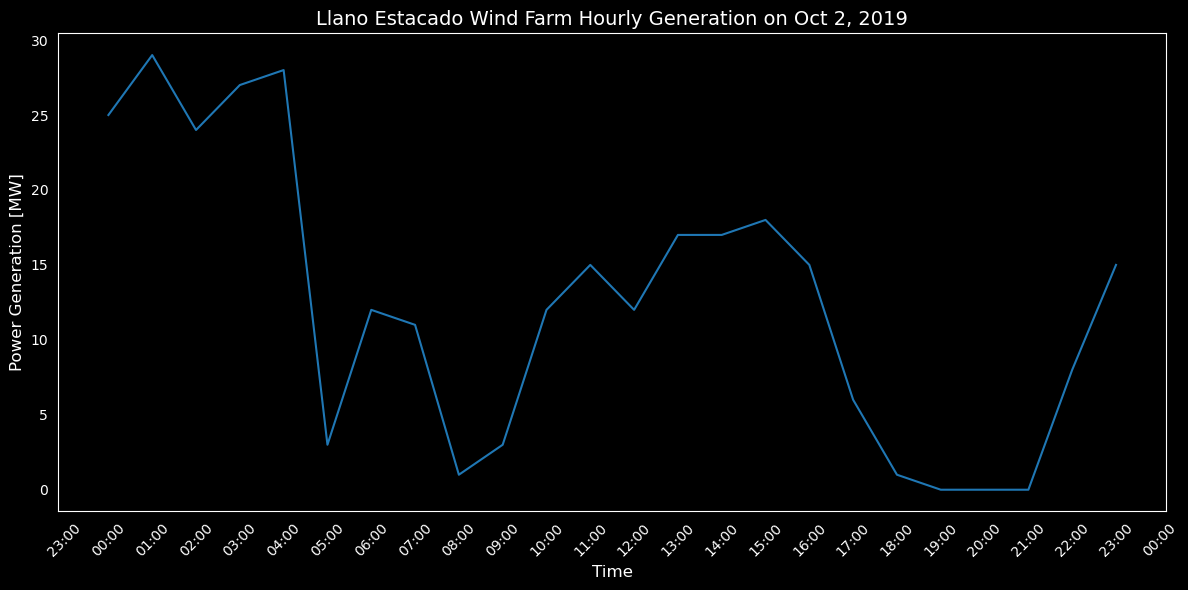

In [ ]:
# Filter data for October 2, 2019
oct_2_data = wind_data.loc["2020-10-02"]

# Plot hourly power generation for October 2, 2019
plt.figure(figsize=(12, 6))
sns.lineplot(data=oct_2_data, x=oct_2_data.index, y=oct_2_data.iloc[:, 6])
plt.title(
    "Llano Estacado Wind Farm Hourly Generation on Oct 2, 2019",
    fontsize=14,
    color="white",
)
plt.xlabel("Time", fontsize=12, color="white")
plt.ylabel("Power Generation [MW]", fontsize=12, color="white")
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")

# Set major ticks to hourly intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the background color of the plot to black
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Solar Simulation Data

In [9]:
# Load simulated solar PV data from RenewablesNinja.api at 20 MW, 0.1 loss, no tracking

# Load the data for 2019
solar_file_path_2019 = Path(
    "renewables_ninja_solar_data/ninja_pv_2019_20mw_0.1loss_notrack.csv"
)

solar_data_2019 = pd.read_csv(
    solar_file_path_2019, usecols=[0, 1, 2], skiprows=3, nrows=8760, header=0
)

print(solar_data_2019.columns)


# Load the data for 2020

solar_file_path_2020 = Path(
    "renewables_ninja_solar_data/ninja_pv_2020_20mw_0.1loss_notrack.csv"
)

solar_data_2020 = pd.read_csv(
    solar_file_path_2020, usecols=[0, 1, 2], skiprows=3, nrows=8784, header=0
)

print(solar_data_2020.columns)


# Concatenate the data

solar_data = pd.concat([solar_data_2019, solar_data_2020], axis=0, ignore_index=True)


print(solar_data.columns)

Index(['time', 'local_time', 'electricity'], dtype='object')
Index(['time', 'local_time', 'electricity'], dtype='object')
Index(['time', 'local_time', 'electricity'], dtype='object')


In [10]:
# Convert local time column to datetime format
solar_data.iloc[:, 1] = pd.to_datetime(solar_data.iloc[:, 1])

# Set the local time column as the index using DatetimeIndex
solar_data.set_index(pd.DatetimeIndex(solar_data.iloc[:, 1]), inplace=True)

# Convert generation data from kW to MW
solar_data.iloc[:, 2] = solar_data.iloc[:, 2] / 1000

# Rename columns to match data, remove spaces, and make all lowercase
solar_data.columns = [
    "solar_date_time",
    "solar_local_time_iso_8601",
    "solar_generation_mw",
]

In [11]:
# Filter data for the specified date range
start_date = "2019-10-01"
end_date = "2019-10-08"
filtered_solar_data = solar_data.loc[start_date:end_date]

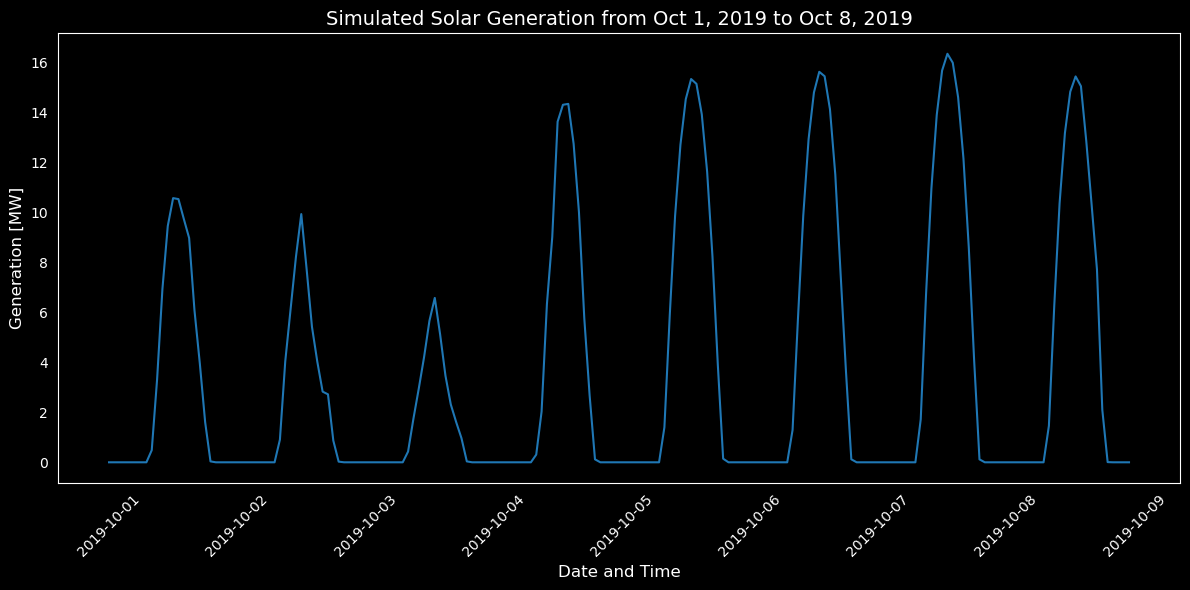

In [12]:
# Plot local time and generation
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=filtered_solar_data,
    x=filtered_solar_data.index,
    y=filtered_solar_data.iloc[:, 2],
)
plt.title(
    "Simulated Solar Generation from Oct 1, 2019 to Oct 8, 2019",
    fontsize=14,
    color="white",
)
plt.xlabel("Date and Time", fontsize=12, color="white")
plt.ylabel("Generation [MW]", fontsize=12, color="white")
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")

# Set major ticks to daily intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the background color of the plot to black
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Merge Data Sets

In [13]:
# Merge the filtered wind and solar data on their datetime index using an inner join
merged_data = pd.merge(
    wind_data, solar_data, left_index=True, right_index=True, how="inner"
)

# Reset the index to include the datetime index as a column
merged_data.reset_index(inplace=True)

# Rename the 'index' column to 'datetime' for clarity
merged_data.rename(columns={"Datetime": "datetime_index"}, inplace=True)

# Set the 'datetime' column as the index
merged_data.set_index("datetime_index", inplace=True)

filtered_merged_data = merged_data.loc[start_date:end_date]

# Copy the merged_data with only desired columns, including the datetime index
desired_columns = [
    "real-time_billing_meter_quantity_[mw]",
    "hourly_wind_forecast_[mw]",
    "solar_generation_mw",
    "real-time_lmp_[$/mwh]",

]
filtered_merged_data = filtered_merged_data[
    desired_columns
].copy()  # Create a copy to avoid SettingWithCopyWarning

# Add a column for total generation in MW
filtered_merged_data.loc[:, "total_generation_mw"] = (
    filtered_merged_data["real-time_billing_meter_quantity_[mw]"]
    + filtered_merged_data["solar_generation_mw"]
)

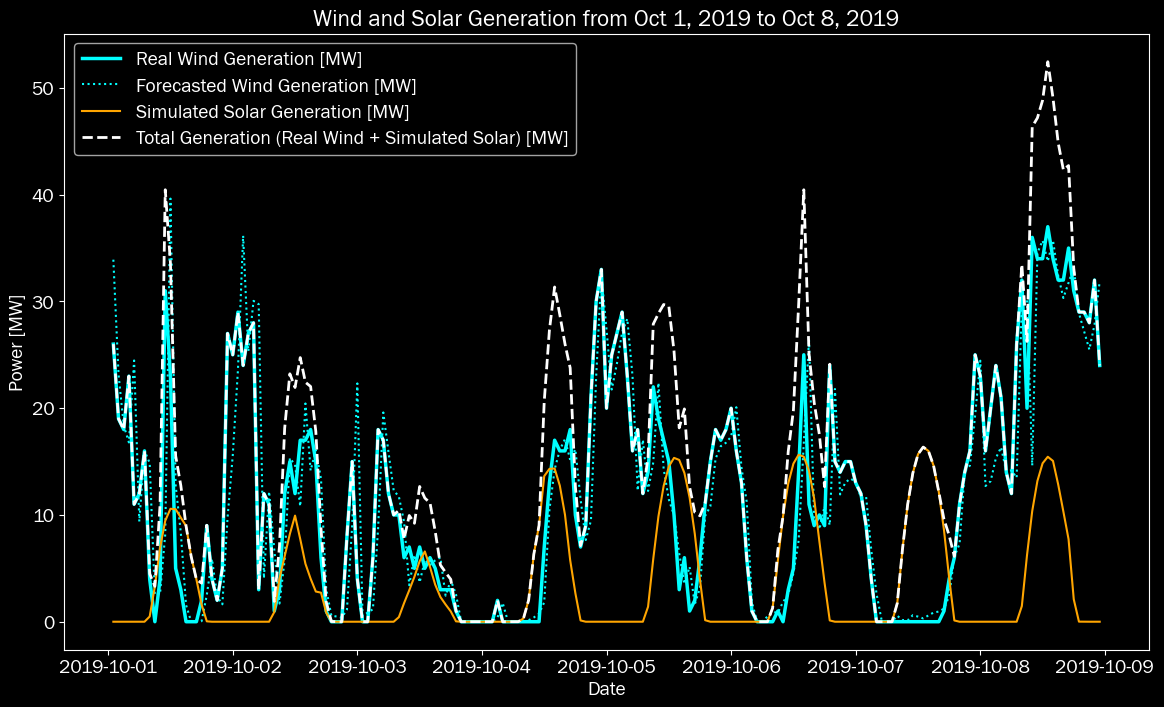

In [14]:
# Set the font to Franklin Gothic and increase font size
plt.rcParams["font.family"] = "Franklin Gothic Book"
plt.rcParams["font.size"] = 14

# Set the background color to black
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["savefig.facecolor"] = "black"

# Plot filtered_merged_data with all columns
plt.figure(figsize=(14, 8))

# Plot real-time billing meter quantity
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["real-time_billing_meter_quantity_[mw]"],
    label="Real Wind Generation [MW]",
    linestyle="-",
    color="cyan",
    linewidth=2.5,
)

# Plot hourly wind forecast
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["hourly_wind_forecast_[mw]"],
    label="Forecasted Wind Generation [MW]",
    linestyle=":",
    color="cyan",
    linewidth=1.5,
)

# Plot solar generation
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["solar_generation_mw"],
    label="Simulated Solar Generation [MW]",
    linestyle="-",
    color="orange",
)

# Plot total generation
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["total_generation_mw"],
    label="Total Generation (Real Wind + Simulated Solar) [MW]",
    linestyle="--",
    color="white",
    linewidth=2,
)

# Adding title and labels
plt.title("Wind and Solar Generation from Oct 1, 2019 to Oct 8, 2019", color="white")
plt.xlabel("Date", color="white")
plt.ylabel("Power [MW]", color="white")

# Change the color of the tick labels and tick marks
plt.tick_params(colors="white", which="both")  # both major and minor ticks are affected

# Change the color of the axes
ax = plt.gca()  # get current axes
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["left"].set_color("white")
ax.spines["right"].set_color("white")

# Change the color of the legend text
legend = plt.legend()
for text in legend.get_texts():
    text.set_color("white")

# Display the plot
plt.show()

Merge Data Set for 1-Day

In [23]:
from datetime import datetime

# Define the target date for filtering
target_date = "2019-10-02"

# Convert the target date to a long format string
# (e.g., "August 02, 2019")
target_date_long_format = datetime.strptime(target_date, "%Y-%m-%d").strftime("%B %d, %Y")
print(f"Target Date in Long Format: {target_date_long_format}")

# Filter wind and solar data for the target date

filtered_wind_data = wind_data.loc[target_date].drop_duplicates()

filtered_solar_data = solar_data.loc[target_date].drop_duplicates()


# Merge the filtered wind and solar data on their datetime index using an inner join

merged_data = pd.merge(
    filtered_wind_data,
    filtered_solar_data,
    left_index=True,
    right_index=True,
    how="inner",
)


# Reset the index to include the datetime index as a column

merged_data.reset_index(inplace=True)


# Rename the 'Datetime' column to 'datetime_index' for clarity

merged_data.rename(columns={"Datetime": "datetime_index"}, inplace=True)

# Set the 'datetime_index' column as the index
merged_data.set_index("datetime_index", inplace=True)


# Copy the merged_data with only desired columns, including the datetime index

desired_columns = [
    "real-time_billing_meter_quantity_[mw]",
    "hourly_wind_forecast_[mw]",
    "solar_generation_mw",
    "real-time_lmp_[$/mwh]",
]

filtered_merged_data = merged_data[
    desired_columns
].copy()  # Create a copy to avoid SettingWithCopyWarning


# Add a column for total generation in MW
filtered_merged_data.loc[:, "total_generation_mw"] = (
    filtered_merged_data["real-time_billing_meter_quantity_[mw]"]
    + filtered_merged_data["solar_generation_mw"]
)

Target Date in Long Format: October 02, 2019


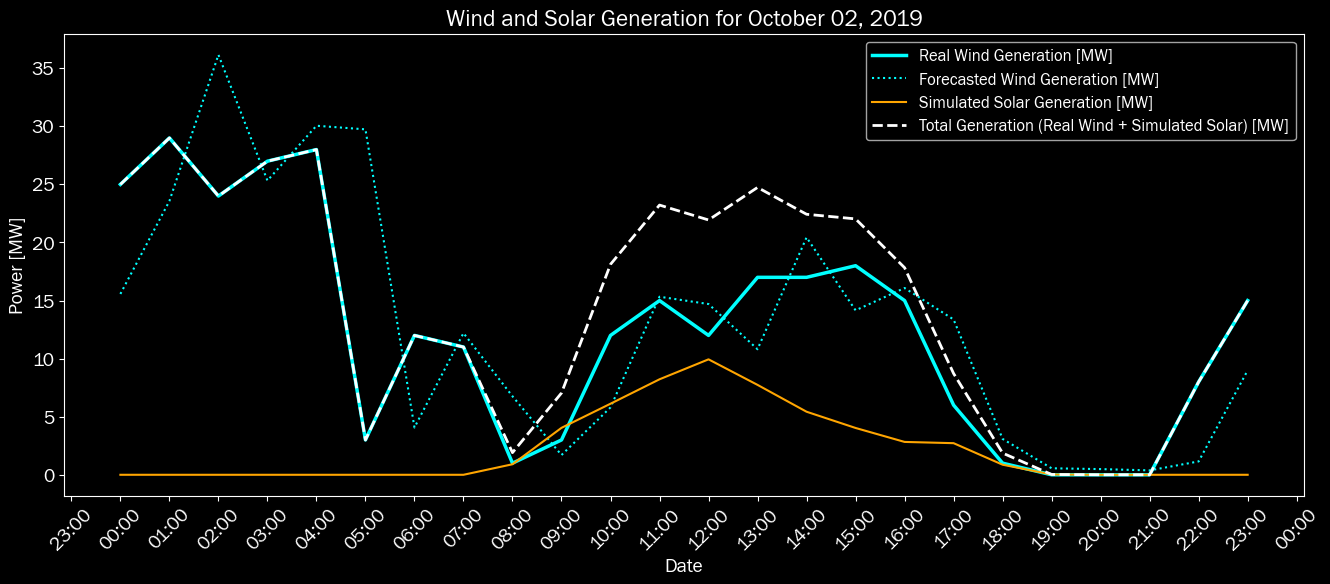

In [24]:
# Set the font to Franklin Gothic and increase font size
plt.rcParams["font.family"] = "Franklin Gothic Book"
plt.rcParams["font.size"] = 14

# Set the background color to black
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["savefig.facecolor"] = "black"

# Make the figure wider
plt.figure(figsize=(16, 6))  # Adjust the width to 16 for a wider plot

# Plot real-time billing meter quantity
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["real-time_billing_meter_quantity_[mw]"],
    label="Real Wind Generation [MW]",
    linestyle="-",
    color="cyan",
    linewidth=2.5,
)

# Plot hourly wind forecast
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["hourly_wind_forecast_[mw]"],
    label="Forecasted Wind Generation [MW]",
    linestyle=":",
    color="cyan",
    linewidth=1.5,
)

# Plot solar generation
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["solar_generation_mw"],
    label="Simulated Solar Generation [MW]",
    linestyle="-",
    color="orange",
)

# Plot total generation
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["total_generation_mw"],
    label="Total Generation (Real Wind + Simulated Solar) [MW]",
    linestyle="--",
    color="white",
    linewidth=2,
)

# Adding title and labels
plt.title(f"Wind and Solar Generation for {target_date_long_format}", color="white")
plt.xlabel("Date", color="white")
plt.ylabel("Power [MW]", color="white")

# Change the color of the tick labels and tick marks
plt.tick_params(colors="white", which="both")  # both major and minor ticks are affected

# Change the color of the axes
ax = plt.gca()  # get current axes
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["left"].set_color("white")
ax.spines["right"].set_color("white")

# Set the date format on the x-axis to show hours in 00:00 format
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(
    mdates.HourLocator(interval=1)
)  # Set tick marks for every hour

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Change the color of the legend text and make it smaller
legend = plt.legend(fontsize=12)  # Set legend font size to 12
for text in legend.get_texts():
    text.set_color("white")

# Display the plot
plt.show()

Generate Electrolyzer Simulation Data

In [ ]:
# Define electrolyzer load constraints (based on H35 Simple Fuel Unit Data)
steady_state_load = 60  # kW
run_idle_load = 0.65  # kW
warm_up_time = 62 / 60  # hour (11:11 to 12:13 on December 16, 2024)
fast_start_up_time = 10 / 60  # hour (13:50 to 14:00 on January 29, 2025)
ramp_down_time = 12 / 60  # hour (15:02 to 15:14 on December 16, 2024)
warm_up_rate = (
    steady_state_load - run_idle_load
) / warm_up_time  # kW/h, required on 1st start-up and if run idle time is > 4 hours
fast_start_up_rate = (
    steady_state_load - run_idle_load
) / fast_start_up_time  # kW/h, required if run idle time is < 4 hours
ramp_down_rate = (steady_state_load - run_idle_load) / ramp_down_time  # kW/h
hydrogen_production_rate = (
    1 / 63.8
)  # kg/kWh, from H35 Simple Fuel Unit Data on steady state operation on December 16, 2024

# Define the electrolyzer load function using the constraints:

# electrolyzer load starts at run_idle_load
# if generation is greater than steady state load, electrolyzer will ramp up using warm_up_rate
# if generation is less than steady state load, electrolyzer will either ramp up or down based on conditions of current load
# electrolyzer cannot operate at more than steady state load, any excess generation is sold to the grid
# electrolyzer cannot be at less than run idle load, any deficit generation is purchased from the grid
# hydrogen only produced when the electrolyzer is running at steady state
# hydrogen is not produced when electrolyzer is operating at less than steady state load


In [29]:
# Extract the 'total_generation_mw' column
total_generation_mw = filtered_merged_data["total_generation_mw"].values
conversion_factor = 1  # Conversion factor from MW to kW
scaling_factor = 300  # % generation scaling factor to match electrolyzer load
scaled_total_generation_kw = (
    total_generation_mw * conversion_factor * (scaling_factor/100.0)
)  # Convert MW to kW and apply scaling factor

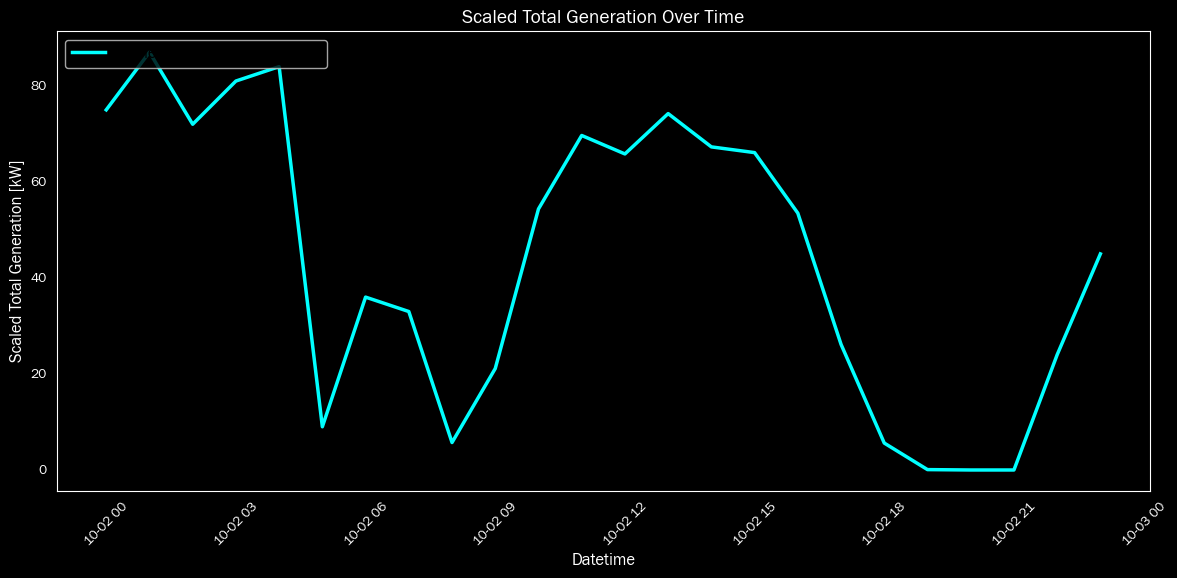

In [30]:
# Plot scaled_total_generation_kw
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_merged_data.index,
    scaled_total_generation_kw,
    label="Scaled Total Generation [kW]",
    linestyle="-",
    color="cyan",
    linewidth=2.5,
)

# Add axis labels
plt.xlabel("Datetime", fontsize=12, color="white")
plt.ylabel("Scaled Total Generation [kW]", fontsize=12, color="white")

# Add title
plt.title("Scaled Total Generation Over Time", fontsize=14, color="white")

# Customize tick marks
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the background color of the plot to black
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

# Add legend
plt.legend(fontsize=12, loc="upper left")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [36]:
# Function to simulate electrolyzer load and hydrogen generation with constraints
def simulate_electrolyzer_operation(
    total_generation_kw,
    steady_state_load,
    run_idle_load,
    warm_up_rate,
    ramp_down_rate,
    hydrogen_production_rate,
):
    """
    Simulates the operation of an electrolyzer based on generation constraints and calculates hydrogen production.

    Args:
        total_generation_kw (array): Array of total generation values in kW.
        steady_state_load (float): Steady-state load of the electrolyzer in kW.
        run_idle_load (float): Run idle load of the electrolyzer in kW.
        warm_up_rate (float): Warm-up rate in kW/h.
        ramp_down_rate (float): Ramp-down rate in kW/h.
        hydrogen_production_rate (float): Hydrogen production rate in kg/kWh.

    Returns:
        dict: A dictionary containing simulated load, hydrogen production, and excess/deficit energy.
    """
    simulated_load = []
    hydrogen_production = []
    excess_energy = []
    deficit_energy = []

    current_load = run_idle_load  # Initialize the electrolyzer load at run_idle_load

    for generation in total_generation_kw:
        if generation >= steady_state_load:
            # Ramp up to steady-state load using warm_up_rate
            if current_load < steady_state_load:
                current_load = min(current_load + warm_up_rate, steady_state_load)
            else:
                current_load = steady_state_load

            # Hydrogen production only at steady-state load
            hydrogen_production.append(current_load * hydrogen_production_rate)

            # Excess energy is sold to the grid
            excess_energy.append(generation - current_load)
            deficit_energy.append(0)
        elif run_idle_load <= generation < steady_state_load:
            # Ramp down to match generation using ramp_down_rate
            if current_load > generation:
                current_load = max(current_load - ramp_down_rate, run_idle_load)
            elif current_load <= generation:
                current_load = min(current_load + warm_up_rate, steady_state_load)
            else:
                current_load = run_idle_load 

            # No hydrogen production during ramping
            hydrogen_production.append(0)

            # No excess or deficit energy
            excess_energy.append(0)
            deficit_energy.append(0)
        else:
            # Generation is below run idle load
            if current_load > run_idle_load:
                current_load = max(current_load - ramp_down_rate, run_idle_load)
            else:
                current_load = run_idle_load

            # No hydrogen production
            hydrogen_production.append(0)

            # Deficit energy is purchased from the grid
            excess_energy.append(0)
            deficit_energy.append(run_idle_load - generation)

        # Append the current load to the simulated load
        simulated_load.append(current_load)

    return {
        "simulated_load": simulated_load,
        "hydrogen_production": hydrogen_production,
        "excess_energy": excess_energy,
        "deficit_energy": deficit_energy,
    }


# Call the function to simulate electrolyzer operation
results = simulate_electrolyzer_operation(
    total_generation_kw=scaled_total_generation_kw,
    steady_state_load=steady_state_load,
    run_idle_load=run_idle_load,
    warm_up_rate=warm_up_rate,
    ramp_down_rate=ramp_down_rate,
    hydrogen_production_rate=hydrogen_production_rate,
)

# Access results
simulated_load = results["simulated_load"]
hydrogen_production = results["hydrogen_production"]
excess_energy = results["excess_energy"]
deficit_energy = results["deficit_energy"]

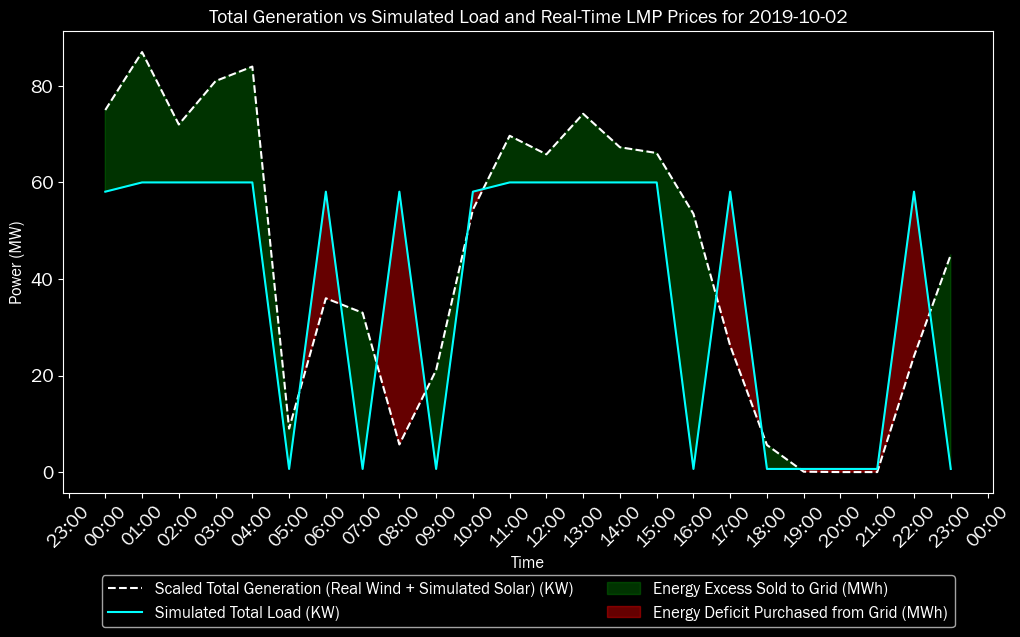

In [ ]:
# Plot the simulated load, generation, and hydrogen production
# Plot the original and simulated generation data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract the 'real_time_lmp_price' column
real_time_lmp_price = filtered_merged_data["real-time_lmp_[$/mwh]"]

# Plot total generation and simulated load on the primary y-axis
sns.lineplot(
    x=filtered_merged_data.index,
    y=scaled_total_generation_kw,
    label="Scaled Total Generation (Real Wind + Simulated Solar) (KW)",
    linestyle="--",
    color="white",
    ax=ax1,
)
sns.lineplot(
    x=filtered_merged_data.index,
    y=simulated_load,
    label="Simulated Total Load (KW)",
    color="cyan",
    ax=ax1,
)

# Shade the area between the curves
ax1.fill_between(
    filtered_merged_data.index,
    scaled_total_generation_kw,
    simulated_load,
    where=(scaled_total_generation_kw > simulated_load),
    interpolate=True,
    color="green",
    alpha=0.4,
    label="Energy Excess Sold to Grid (MWh)",
)
ax1.fill_between(
    filtered_merged_data.index,
    scaled_total_generation_kw,
    simulated_load,
    where=(simulated_load > scaled_total_generation_kw),
    interpolate=True,
    color="red",
    alpha=0.4,
    label="Energy Deficit Purchased from Grid (MWh)",
)

# Set labels and title for the primary y-axis
ax1.set_title(
    f"Total Generation vs Simulated Load and Real-Time LMP Prices for {target_date}",
    fontsize=14,
    color="white",
)
ax1.set_xlabel("Time", fontsize=12, color="white")
ax1.set_ylabel("Power (MW)", fontsize=12, color="white")
ax1.tick_params(axis="x", rotation=45, colors="white")
ax1.tick_params(axis="y", colors="white")

# Set the axes lines to white
ax1.spines["bottom"].set_color("white")
ax1.spines["top"].set_color("white")
ax1.spines["right"].set_color("white")
ax1.spines["left"].set_color("white")

# Set the date format on the x-axis to show hours in 00:00 format
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.xaxis.set_major_locator(
    mdates.HourLocator(interval=1)
)  # Set tick marks for every hour

# # Create a secondary y-axis to plot the real-time LMP price
# ax2 = ax1.twinx()
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=real_time_lmp_price,
#     label="Real-Time LMP Price ($/MWh)",
#     color="yellow",
#     ax=ax2,
# )
# ax2.set_ylabel("Real-Time LMP Price ($/MWh)", fontsize=12, color="yellow")
# ax2.tick_params(axis="y", colors="yellow")

# Combine legends from both y-axes and place them below the plot
lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(
    # lines + lines2,
    # labels + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.16),
    fontsize=12,
    ncol=2,
)

# # Remove the legend box on the top right corner
# ax2.get_legend().remove()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color("white")

# Show the plot
plt.show()

Calculate Simulated Energy Deficits & Excess and Associated Cost

In [ ]:
from scipy.integrate import simpson

# Initialize a list to store the area differences for each hour
negative_hourly_area_differences = []

# Loop through each hour and calculate the area difference if the condition is met
for i in range(1, len(scaled_total_generation_kw)):
    if simulated_load_kw[i] > scaled_total_generation_kw[i]:
        # Calculate the area under the curve for the original total generation data for the current hour
        area_original_hour = simpson(total_generation_mw[i - 1 : i + 1], dx=1)

        # Calculate the area under the curve for the simulated total generation data for the current hour
        area_simulated_hour = simpson(simulated_load[i - 1 : i + 1], dx=1)

        # Calculate the difference in the areas for the current hour
        area_difference_hour = area_simulated_hour - area_original_hour

        # Append the area difference to the list
        negative_hourly_area_differences.append((i, area_difference_hour))

# Print the hourly area differences
for hour, diff in negative_hourly_area_differences:
    print(f"At hour {hour}:00, the area difference: {diff:.2f} MWh")

In [ ]:
# Calculate the total hourly area differences that would require energy purchase from the grid
negative_total_area_difference = sum(
    diff for _, diff in negative_hourly_area_differences if diff > 0
)
print(
    f"This wind and solar power simulation would require {negative_total_area_difference:.2f} MWh of energy to be purchased from the grid."
)

# Calculate the cost of this energy purchase based on the corresponding hourly real-time LMP price
total_cost = sum(
    diff * oct_2_merged_data.iloc[hour]["real-time_lmp_[$/mwh]"]
    for hour, diff in negative_hourly_area_differences
    if diff > 0
)
print(f"The total cost of the energy purchase from the grid is ${total_cost:.2f}")

In [ ]:
from scipy.integrate import simpson

# Initialize a list to store the area differences for each hour
positive_hourly_area_differences = []

# Loop through each hour and calculate the area difference if the condition is met
for i in range(1, len(scaled_total_generation_kw)):
    if scaled_total_generation_kw[i] > simulated_load_kw[i]:
        # Calculate the area under the curve for the original total generation data for the current hour
        area_original_hour = simpson(scaled_total_generation_kw[i - 1 : i + 1], dx=1)

        # Calculate the area under the curve for the simulated total generation data for the current hour
        area_simulated_hour = simpson(simulated_load_kw[i - 1 : i + 1], dx=1)

        # Calculate the difference in the areas for the current hour
        area_difference_hour = area_original_hour - area_simulated_hour

        # Append the area difference to the list
        positive_hourly_area_differences.append((i, area_difference_hour))

# Print the hourly area differences
for hour, diff in positive_hourly_area_differences:
    print(f"At hour {hour}:00, the area difference: {diff:.2f} MWh")

In [ ]:
# Calculate the total hourly area differences that would require energy sale to the grid
positive_total_area_difference = sum(
    diff for _, diff in positive_hourly_area_differences if diff > 0
)
print(
    f"This wind and solar power simulation would require {positive_total_area_difference:.2f} MWh of energy to be sold to the grid."
)

# Calculate the revenue from this energy sale based on the corresponding hourly real-time LMP price
total_revenue = sum(
    diff * filtered_merged_data.iloc[hour]["real-time_lmp_[$/mwh]"]
    for hour, diff in positive_hourly_area_differences
    if diff > 0
)
print(f"The total revenue from energy sales to the grid is ${total_revenue:.2f}")

In [ ]:
# Calculate the net energy from the energy sales and purchases
net_energy = positive_total_area_difference - negative_total_area_difference
print(
    f"The net energy from energy sales and purchases is {net_energy:.2f} MWh."
)  # Calculate the net revenue from the energy sales and purchases
if net_energy > 0:
    print(f"Sold more energy than purchased from the grid.")
else:
    print(f"Purchased more energy than sold to the grid.")

net_revenue = total_revenue - total_cost
print(f"The net revenue from energy sales and purchases is ${net_revenue:.2f}.")
if net_revenue > 0:
    print(f"Profited from the energy sales.")

Determine during which times of the day is LMP price highest using data set

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_data is already loaded as a DataFrame
# merged_data = pd.read_csv('path_to_your_dataset.csv')

# Extract the hour from the datetime index
merged_data["hour"] = merged_data.index.hour

# Calculate the correlation between the hour and the LMP price
correlation = merged_data[["hour", "real-time_lmp_[$/mwh]"]].corr()
print("Correlation between hour and LMP price:")
print(correlation)

# Prepare the data for machine learning
X = merged_data[["hour"]]
y = merged_data["real-time_lmp_[$/mwh]"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# # Plot the actual vs predicted LMP prices
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=X_test['hour'], y=y_test, label='Actual', color='blue')
# sns.scatterplot(x=X_test['hour'], y=y_pred, label='Predicted', color='red')
# plt.title('Actual vs Predicted LMP Prices', color='white')
# plt.xlabel('Hour of the Day', color='white')
# plt.ylabel('Real-Time LMP Price [$/MWh]', color='white')

# # Customize plot appearance
# ax = plt.gca()
# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')

# # Set the legend text color to white and background to transparent
# legend = plt.legend()
# for text in legend.get_texts():
#     text.set_color('white')
# legend.get_frame().set_facecolor('none')

# plt.show()

# Identify outliers in the actual data
outliers = y_test[(y_test - y_pred).abs() > 2 * mse**0.5]

# Plot the outliers with labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test["hour"], y=y_test, label="Actual", color="blue")
sns.scatterplot(x=X_test["hour"], y=y_pred, label="Predicted", color="red")
for idx, value in outliers.items():
    plt.text(
        X_test.loc[idx, "hour"],
        value,
        idx.strftime("%b-%d"),
        color="yellow",
        fontsize=10,
        ha="right",
    )

# Extract the first and last date from the merged_data index
from_date = merged_data.index.min().strftime("%Y-%m-%d")
to_date = merged_data.index.max().strftime("%Y-%m-%d")

plt.title(
    f"Actual vs Predicted Real-Time LMP Prices from {from_date} to {to_date}",
    color="white",
)
plt.xlabel("Hour of the Day", color="white")
plt.ylabel("Real-Time LMP Price [$/MWh]", color="white")

# Customize plot appearance
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the legend text color to white and background to transparent
legend = plt.legend()
for text in legend.get_texts():
    text.set_color("white")
legend.get_frame().set_facecolor("none")

plt.show()

In [ ]:
# Determine the times of the day when the LMP price is typically highest
average_lmp_by_hour = merged_data.groupby("hour")["real-time_lmp_[$/mwh]"].mean()

# Plot the average LMP price by hour
plt.figure(figsize=(10, 6))
sns.lineplot(x=average_lmp_by_hour.index, y=average_lmp_by_hour.values, color="blue")
plt.title("Average Real-Time LMP Price by Hour of the Day", color="white")
plt.xlabel("Hour of the Day", color="white")
plt.ylabel("Average Real-Time LMP Price [$/MWh]", color="white")
plt.xticks(color="white")
plt.yticks(color="white")

# Add labels to points on the line for every hour
for hour, price in average_lmp_by_hour.items():
    plt.text(
        hour,
        price,
        f"${price:.0f}",
        color="white",
        fontsize=11,
        ha="center",
        va="bottom",
    )

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the background color of the plot to black
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

plt.show()